[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/natrask/ENM5320-2026/blob/main/NewMaterial/fullNonlinearSolve/inclass_nonlinearStencil_solution.ipynb)

In [13]:
import urllib.request, os
soap_url = "https://raw.githubusercontent.com/nikhilvyas/SOAP/main/soap.py"
if not os.path.exists("soap.py"):
    urllib.request.urlretrieve(soap_url, "soap.py")
    print("Downloaded soap.py")
else:
    print("soap.py already present")
from soap import SOAP
print("SOAP optimizer imported successfully")

Downloaded soap.py
SOAP optimizer imported successfully


# Nonlinear MLP Stencil: Learning State-Dependent Finite Differences from Shear-Flow Data

This notebook combines the **data-loading pipeline** from
`inclass_linearStencil_solution.ipynb` with the **nonlinear MLP stencil**
approach from `nonlinear.ipynb`.

**Key idea:** Instead of learning 3 fixed (linear) stencil coefficients, we
use an MLP that outputs stencil coefficients as a function of the local
solution state:

$$L[u]_i = \sum_{j \sim i} \bigl(c_j + \delta a_j(\mathbf{u}_{\text{stencil}})\bigr)\, u_j$$

where $\delta a_j$ is an MLP perturbation on top of a base centered-difference
stencil $c_j = [1, -2, 1]/\Delta x^2$.

**Design choices:**
- The stencil is a **nonlinear perturbation** of a centered-difference Laplacian.
  At initialisation the MLP's final layer is zero, so $L[u] = D_{xx} u$ exactly.
- Time integration is **implicit Euler** (unconditionally stable), requiring a
  Newton solve at each time step.
- The Newton Jacobian is assembled via `vmap`/`jacrev` on the local
  stencil function and scattered into a dense banded matrix.
- Gradients flow through the Newton solve via the **implicit function theorem**
  (one differentiable correction step after convergence).

## 0. Load Shear-Flow Dataset

In [14]:
# ========================
# MODIFY THESE PARAMETERS
# ========================

# Reynolds number: Valid options are 1e4, 5e4, 1e5, 5e5
Re = 5e5

# Schmidt number: Valid options are 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0
Sc = 2.0e-1

# Initial condition index: 0-39
ic_index = 0

print(f"Target simulation:")
print(f"  Reynolds number: {Re:.0e}")
print(f"  Schmidt number: {Sc:.1f}")
print(f"  Initial condition: {ic_index}")

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import urllib.request
import os

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("\u2713 Libraries imported")

# Construct filename from parameters
filename = f'shearflow_1d_profiles_Re{Re:.0e}_Sc{Sc:.1e}_ic{ic_index}.npz'

# Check if file exists locally
if not Path(filename).exists():
    print(f"\ud83d\udce5 File not found locally: {filename}")
    print(f"   Attempting to download from GitHub repository...")

    # Construct GitHub raw URL
    github_base = "https://raw.githubusercontent.com/natrask/ENM5320-2026/main/NewMaterial/shearflow_project/"
    github_url = github_base + filename

    try:
        print(f"   URL: {github_url}")
        print(f"   Downloading... (this may take a minute for large files)")

        # Download the file
        urllib.request.urlretrieve(github_url, filename)

        file_size_mb = os.path.getsize(filename) / (1024**2)
        print(f"   \u2713 Download complete! ({file_size_mb:.2f} MB)")
        print(f"   Saved to: {Path.cwd() / filename}")

    except urllib.error.HTTPError as e:
        print(f"   \u274c Download failed: {e}")
        print(f"\n   This file may not exist in the repository yet.")
        print(f"   Please run shearflow_preprocessing.ipynb to generate it,")
        print(f"   or choose different parameters (Re, Sc, ic_index).")
        raise FileNotFoundError(f"Could not find or download {filename}")
    except Exception as e:
        print(f"   \u274c Unexpected error: {e}")
        raise
else:
    print(f"\u2713 Found file locally: {filename}")

# Load the data
data = np.load(filename)

print(f"\n\u2713 Data loaded successfully")
print(f"\nAvailable keys in NPZ file:")
for key in data.keys():
    if isinstance(data[key], np.ndarray):
        print(f"  {key:20s}: shape={str(data[key].shape):20s} dtype={data[key].dtype}")
    else:
        print(f"  {key:20s}: {data[key]}")

# Extract basic info
print(f"\nSimulation parameters:")
print(f"  Reynolds number: {data['Re']}")
print(f"  Schmidt number: {data['Sc']}")
print(f"  Initial condition: {data['ic_index']}")

print(f"\nData dimensions:")
print(f"  Time steps: {len(data['time'])}")
print(f"  Spatial points: {len(data['x'])}")
print(f"  Time range: [{data['time'][0]:.2f}, {data['time'][-1]:.2f}]")
print(f"  Spatial range: [{data['x'][0]:.2f}, {data['x'][-1]:.2f}]")

Target simulation:
  Reynolds number: 5e+05
  Schmidt number: 0.2
  Initial condition: 0
✓ Libraries imported
✓ Found file locally: shearflow_1d_profiles_Re5e+05_Sc2.0e-01_ic0.npz

✓ Data loaded successfully

Available keys in NPZ file:
  time                : shape=(200,)               dtype=float64
  x                   : shape=(512,)               dtype=float32
  tracer_mean         : shape=(200, 512)           dtype=float32
  tracer_std          : shape=(200, 512)           dtype=float32
  Re                  : shape=()                   dtype=float64
  Sc                  : shape=()                   dtype=float64
  ic_index            : shape=()                   dtype=int32
  velocity_x_mean     : shape=(200, 512)           dtype=float32
  velocity_x_std      : shape=(200, 512)           dtype=float32
  velocity_y_mean     : shape=(200, 512)           dtype=float32
  velocity_y_std      : shape=(200, 512)           dtype=float32
  velocity_mag_mean   : shape=(200, 512)          

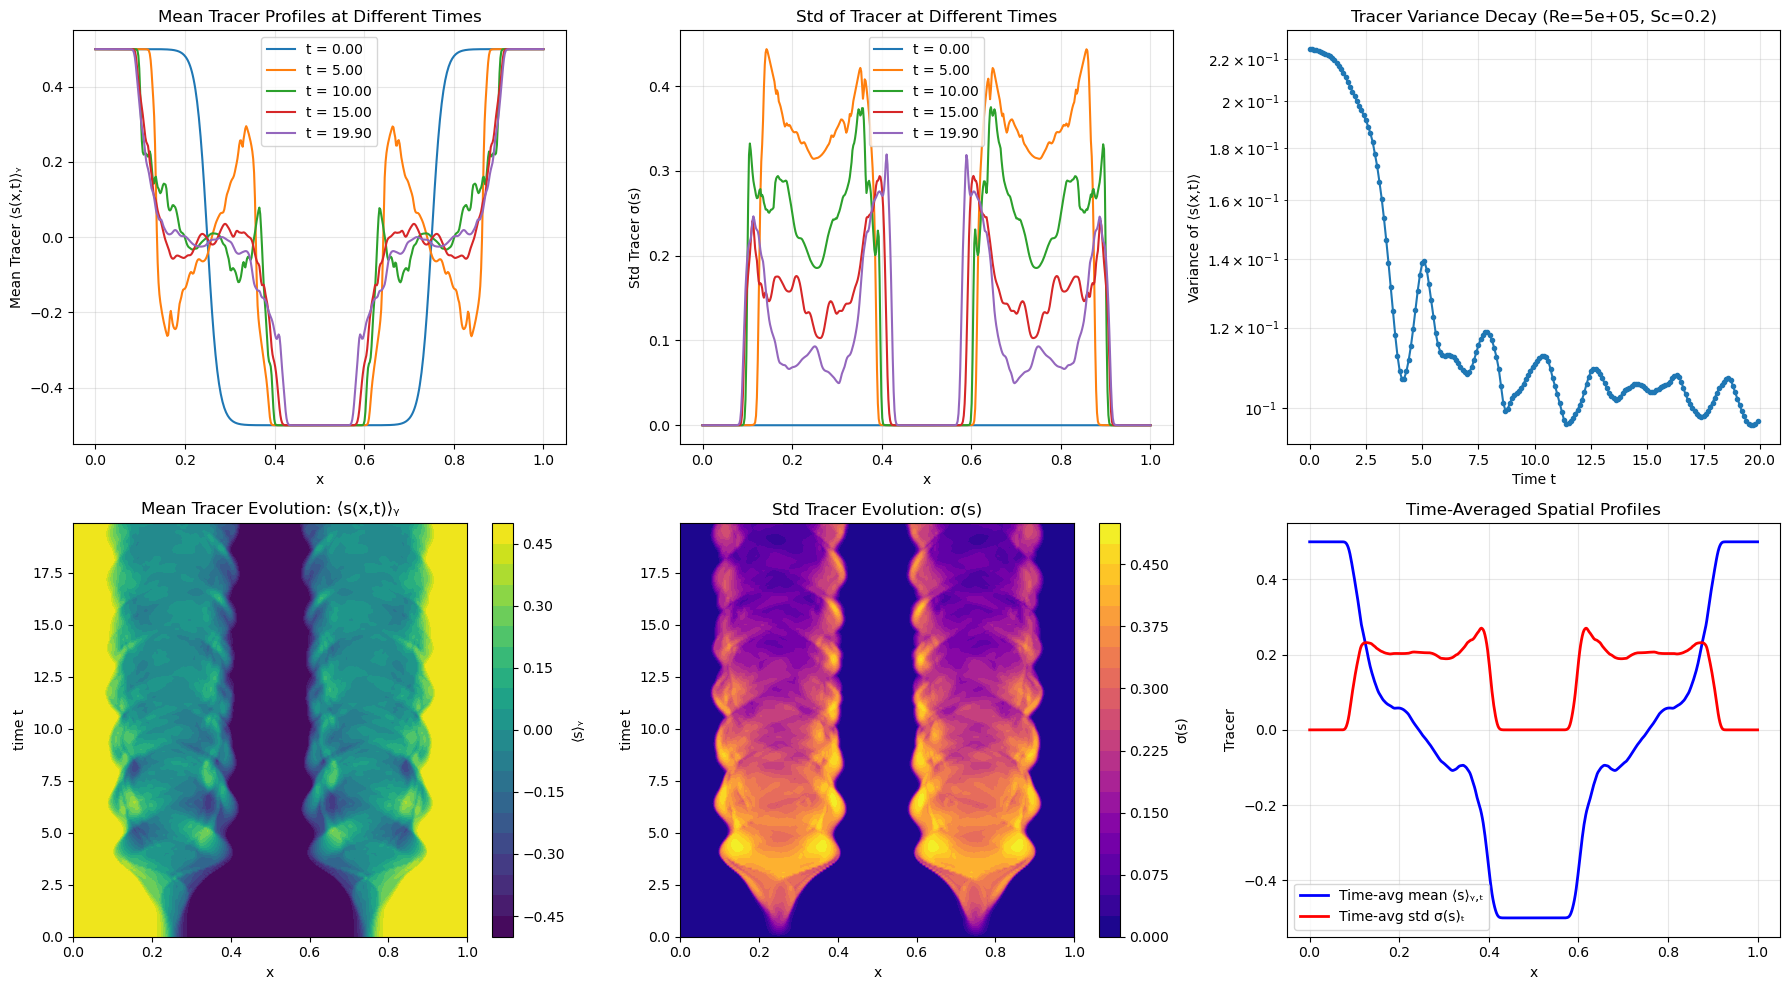


✓ Tracer visualizations complete


In [15]:
# Extract tracer data
time_raw = data['time']
x_raw = data['x']
tracer_mean = data['tracer_mean']
tracer_std = data['tracer_std']

# Create figure with tracer visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Select time indices for 1D plots (start, 1/4, 1/2, 3/4, end)
n_time = len(time_raw)
time_indices = [0, n_time//4, n_time//2, 3*n_time//4, n_time-1]

# Plot 1: Mean tracer at different time snapshots
ax = axes[0, 0]
for t_idx in time_indices:
    ax.plot(x_raw, tracer_mean[t_idx, :], label=f't = {time_raw[t_idx]:.2f}')
ax.set_xlabel('x')
ax.set_ylabel('Mean Tracer \u27e8s(x,t)\u27e9\u1d67')
ax.set_title('Mean Tracer Profiles at Different Times')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Std tracer at different time snapshots
ax = axes[0, 1]
for t_idx in time_indices:
    ax.plot(x_raw, tracer_std[t_idx, :], label=f't = {time_raw[t_idx]:.2f}')
ax.set_xlabel('x')
ax.set_ylabel('Std Tracer \u03c3(s)')
ax.set_title('Std of Tracer at Different Times')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Variance decay over time
ax = axes[0, 2]
variance_over_time = np.var(tracer_mean, axis=1)
ax.semilogy(time_raw, variance_over_time, 'o-', markersize=3)
ax.set_xlabel('Time t')
ax.set_ylabel('Variance of \u27e8s(x,t)\u27e9')
ax.set_title(f'Tracer Variance Decay (Re={Re:.0e}, Sc={Sc:.1f})')
ax.grid(True, alpha=0.3, which='both')

# Plot 4: Heatmap of mean tracer evolution
ax = axes[1, 0]
im = ax.contourf(x_raw, time_raw, tracer_mean, levels=20, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('time t')
ax.set_title('Mean Tracer Evolution: \u27e8s(x,t)\u27e9\u1d67')
plt.colorbar(im, ax=ax, label='\u27e8s\u27e9\u1d67')

# Plot 5: Heatmap of std tracer evolution
ax = axes[1, 1]
im = ax.contourf(x_raw, time_raw, tracer_std, levels=20, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('time t')
ax.set_title('Std Tracer Evolution: \u03c3(s)')
plt.colorbar(im, ax=ax, label='\u03c3(s)')

# Plot 6: Time-averaged spatial profiles
ax = axes[1, 2]
mean_spatial = np.mean(tracer_mean, axis=0)
std_spatial = np.mean(tracer_std, axis=0)
ax.plot(x_raw, mean_spatial, 'b-', linewidth=2, label='Time-avg mean \u27e8s\u27e9\u1d67,\u209c')
ax.plot(x_raw, std_spatial, 'r-', linewidth=2, label='Time-avg std \u03c3(s)\u209c')
ax.set_xlabel('x')
ax.set_ylabel('Tracer')
ax.set_title('Time-Averaged Spatial Profiles')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n\u2713 Tracer visualizations complete")

## 1. Setup: imports and device

In [16]:
import torch
import torch.nn as nn
from torch.func import jacrev, vmap, functional_call

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


## 2. Prepare training data

Subsample the loaded shear-flow data in space and skip early transients
(identical to the linear-stencil notebook).

In [17]:
n_skip = 2          # Number of initial timesteps to skip
x_subsample = 10    # Spatial subsampling factor  (10x downsample)
t_subsample = 10    # Temporal subsampling factor  (10x downsample)

x = data['x'][::x_subsample]
time = data['time'][n_skip::t_subsample]
tracer_mean_sub = data['tracer_mean'][n_skip::t_subsample, ::x_subsample]

N = len(x)
M = len(time) - 1

dx = x[1] - x[0]
dt = time[1] - time[0]

u_true_snapshots = torch.tensor(tracer_mean_sub, dtype=torch.float32).to(device)

print(f"Data preparation complete:")
print(f"  N (spatial points): {N}")
print(f"  M (training timesteps): {M}")
print(f"  dx (spatial step): {dx:.4f}")
print(f"  dt (time step): {dt:.4f}")
print(f"  u_true_snapshots shape: {u_true_snapshots.shape}")

Data preparation complete:
  N (spatial points): 52
  M (training timesteps): 19
  dx (spatial step): 0.0196
  dt (time step): 1.0000
  u_true_snapshots shape: torch.Size([20, 52])


## 3. Define the nonlinear MLP stencil

The MLP takes a 3-element local stencil window $[u_{i-1}, u_i, u_{i+1}]$ and
outputs 3 perturbation weights $[\delta a_{-1}, \delta a_0, \delta a_1]$.

The effective stencil at node $i$ is:
$$a_k^{(i)} = \underbrace{c_k}_{\text{centered diff}} + \underbrace{\delta a_k(\mathbf{u}_{\text{stencil}})}_\text{MLP perturbation}$$

Because the final linear layer is initialised to **zero**, the MLP perturbation
vanishes at the start of training, guaranteeing that the initial operator is
the standard Laplacian.

In [20]:
class StencilMLP(nn.Module):
    """MLP: local window -> stencil perturbation.  Final layer zero-init."""
    def __init__(self, stencil_width=3, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(stencil_width, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden),        nn.Tanh(),
            nn.Linear(hidden, stencil_width),
        )
        # Zero-initialise final layer so perturbation is zero at start
        with torch.no_grad():
            self.net[-1].weight.zero_()
            self.net[-1].bias.zero_()

    def forward(self, u_local):
        return self.net(u_local)

## 4. Stencil helpers and implicit-Euler residual

We define:
- `extract_stencil_windows` — periodic padding + unfolding
- `apply_nonlinear_stencil` — base + MLP perturbation applied to all nodes
- `implicit_euler_residual` — $F(u^{n+1}) = u^{n+1} - u^n - \Delta t\, L[u^{n+1}]$

In [21]:
def extract_stencil_windows(u, stencil_radius=1):
    """Extract all local stencil windows from u with periodic BCs.
    Returns: (N, 2*stencil_radius+1) tensor of local windows."""
    N = u.shape[0]
    width = 2 * stencil_radius + 1
    u_padded = torch.cat([u[-stencil_radius:], u, u[:stencil_radius]])
    return u_padded.unfold(0, width, 1)


def apply_nonlinear_stencil(u, mlp_params, mlp_buffers, mlp_forward, base_coeffs):
    """Apply L[u]_i = sum_k (base + delta_a_k(window_i)) * window_i[k]."""
    windows = extract_stencil_windows(u)
    delta_a = mlp_forward(mlp_params, mlp_buffers, windows)
    a_eff = base_coeffs.unsqueeze(0) + delta_a
    return (a_eff * windows).sum(dim=1)


def implicit_euler_residual(u_new, u_old, dt, mlp_params, mlp_buffers,
                            mlp_forward, base_coeffs):
    """F(u_new) = u_new - u_old - dt * L[u_new]."""
    Lu = apply_nonlinear_stencil(u_new, mlp_params, mlp_buffers,
                                 mlp_forward, base_coeffs)
    return u_new - u_old - dt * Lu

## 5. Jacobian assembly (dense, O(N) local jacrev calls)

Each row $i$ of the residual depends only on nodes $\{i-1, i, i+1\}$.
We compute the $3\times3$ local Jacobian $\partial F_i / \partial (u_{i-1}, u_i, u_{i+1})$
via `jacrev`, `vmap` over all nodes, then scatter into a dense $(N \times N)$ matrix.

In [22]:
def assemble_jacobian_banded(u_new, u_old, dt, mlp_params, mlp_buffers,
                             mlp_forward, base_coeffs):
    """Assemble the full Jacobian as a dense matrix using O(N) local jacrev calls.
    
    Each row i has at most 3 nonzero entries (columns i-1, i, i+1 mod N).
    We compute all local Jacobians with vmap+jacrev for efficiency.
    """
    N = u_new.shape[0]
    windows = extract_stencil_windows(u_new)  # (N, 3)

    # Define a function from local window -> scalar residual for one node
    def local_res_fn(u_local_3, u_old_i):
        delta_a = mlp_forward(mlp_params, mlp_buffers,
                              u_local_3.unsqueeze(0)).squeeze(0)
        a_eff = base_coeffs + delta_a
        Lu_i = (a_eff * u_local_3).sum()
        return u_local_3[1] - u_old_i - dt * Lu_i

    # jacrev of local_res_fn w.r.t. first arg (the 3-element window)
    local_jac_fn = jacrev(local_res_fn, argnums=0)  # returns (3,) per call

    # vmap over all N windows simultaneously
    all_local_jacs = vmap(local_jac_fn)(windows, u_old)  # (N, 3)

    # Scatter into dense (N, N) matrix
    J = torch.zeros(N, N, dtype=u_new.dtype, device=u_new.device)
    idx = torch.arange(N, device=u_new.device)
    for k in range(3):  # k=0 -> col i-1, k=1 -> col i, k=2 -> col i+1
        col = (idx + (k - 1)) % N
        J[idx, col] = all_local_jacs[:, k]

    return J

## 6. Newton solver with Armijo backtracking

All Newton iterations are detached. A single differentiable correction step
is applied at the end (implicit function theorem) so that gradients flow
through `mlp_params` even when Newton converges quickly.

In [23]:
def newton_solve(u_init, u_old, dt, mlp_params, mlp_buffers, mlp_forward,
                 base_coeffs, tol=1e-10, max_iter=20, verbose=False):
    """Solve F(u) = u - u_old - dt*L[u] = 0 via Newton + Armijo backtracking.
    
    All Newton iterations are detached. A single differentiable correction step
    is applied at the end (implicit function theorem) so that gradients flow
    through mlp_params even when Newton converges quickly.
    
    Returns the converged u^{n+1} with grad_fn attached.
    """
    u = u_init.detach().clone()

    for k in range(max_iter):
        with torch.no_grad():
            F_val = implicit_euler_residual(u, u_old, dt, mlp_params, mlp_buffers,
                                            mlp_forward, base_coeffs)
            res_norm = F_val.norm().item()
            if verbose:
                print(f"  Newton iter {k}: ||F|| = {res_norm:.3e}")
            if res_norm < tol:
                break

        # jacrev needs autograd enabled
        with torch.enable_grad():
            J = assemble_jacobian_banded(u, u_old, dt, mlp_params, mlp_buffers,
                                         mlp_forward, base_coeffs)
        with torch.no_grad():
            delta_u = torch.linalg.solve(J.detach(), -F_val)

            # Armijo backtracking
            alpha = 1.0
            c1 = 1e-4
            tau = 0.5
            phi_current = 0.5 * F_val.dot(F_val)
            directional_deriv = -F_val.dot(F_val)

            for _ in range(20):
                u_trial = u + alpha * delta_u
                F_trial = implicit_euler_residual(u_trial, u_old, dt, mlp_params,
                                                  mlp_buffers, mlp_forward, base_coeffs)
                phi_trial = 0.5 * F_trial.dot(F_trial)
                if phi_trial <= phi_current + c1 * alpha * directional_deriv:
                    break
                alpha *= tau

            u = u + alpha * delta_u

    # --- Differentiable correction (implicit function theorem) ---
    u_detached = u.detach()
    F_val = implicit_euler_residual(u_detached, u_old, dt, mlp_params, mlp_buffers,
                                    mlp_forward, base_coeffs)
    J = assemble_jacobian_banded(u_detached, u_old, dt, mlp_params, mlp_buffers,
                                 mlp_forward, base_coeffs)
    delta_u = torch.linalg.solve(J, -F_val)
    u_out = u_detached + delta_u

    return u_out

## 7. Instantiate model and base stencil

In [24]:
# Base (linear) centered-difference stencil: [1, -2, 1] / dx^2
base_coeffs = torch.tensor([1.0, -2.0, 1.0], device=device) / (dx ** 2)

mlp = StencilMLP(stencil_width=3, hidden=16).to(device)

# Pure-function forward pass for compatibility with vmap/jacrev
mlp_params = dict(mlp.named_parameters())
mlp_buffers = dict(mlp.named_buffers())

def mlp_forward(params, buffers, x):
    return functional_call(mlp, (params, buffers), (x,))

# Verify: at init the perturbation should be ~zero
test_window = torch.randn(1, 3, device=device)
print(f"MLP output at init (should be ~0): {mlp_forward(mlp_params, mlp_buffers, test_window)}")
print(f"\nBase stencil: {base_coeffs.tolist()}")
print(f"Grid: N={N}, dx={dx:.4f}")
print(f"Time: M={M} steps, dt={dt:.6f}")

MLP output at init (should be ~0): tensor([[0., 0., 0.]], grad_fn=<AddmmBackward0>)

Base stencil: [2611.2099609375, -5222.419921875, 2611.2099609375]
Grid: N=52, dx=0.0196
Time: M=19 steps, dt=1.000000


## 8. Verify Newton solver at initialisation

With the MLP perturbation equal to zero, implicit Euler with the nonlinear
solver should match a direct linear solve with the base Laplacian stencil.

In [25]:
u0 = u_true_snapshots[0].clone()
u1_newton = newton_solve(u0, u0, dt, mlp_params, mlp_buffers, mlp_forward,
                         base_coeffs, tol=1e-10, max_iter=10, verbose=True)

# Reference: dense linear solve with base stencil
D_lin = torch.zeros(N, N, device=device)
for i in range(N):
    D_lin[i, (i-1) % N] = base_coeffs[0]
    D_lin[i, i]          = base_coeffs[1]
    D_lin[i, (i+1) % N] = base_coeffs[2]
A_lin = torch.eye(N, device=device) - dt * D_lin
u1_linear = torch.linalg.solve(A_lin, u0)

print(f"\n||Newton - LinearSolve|| = {(u1_newton - u1_linear).norm():.3e}  (should be ~0)")

  Newton iter 0: ||F|| = 1.125e+03
  Newton iter 1: ||F|| = 1.041e-03
  Newton iter 2: ||F|| = 2.534e-05
  Newton iter 3: ||F|| = 2.340e-05
  Newton iter 4: ||F|| = 2.273e-05
  Newton iter 5: ||F|| = 2.043e-05
  Newton iter 6: ||F|| = 1.712e-05
  Newton iter 7: ||F|| = 1.712e-05
  Newton iter 8: ||F|| = 1.712e-05
  Newton iter 9: ||F|| = 1.712e-05

||Newton - LinearSolve|| = 2.638e-06  (should be ~0)


## 9. Training loop

In [ ]:
# Unroll a small window of M_train steps per epoch, randomly sampled from the trajectory.
M_train = min(5, M)

optimizer = SOAP(mlp.parameters(), lr=3e-3, betas=(0.95, 0.95),
                 weight_decay=0.01, precondition_frequency=10)
num_epochs = 500

print(f"Training with M_train={M_train} unrolled steps (out of {M} total), random start each epoch")
print(f"Optimizer: SOAP (lr=3e-3, betas=(0.95,0.95), precondition_frequency=10)")
print(f"{'Epoch':<8} {'Start':<8} {'Loss':<15}")
print("-" * 35)

loss_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Randomly pick a starting index so the model sees different parts of the trajectory
    start = torch.randint(0, M - M_train + 1, (1,)).item()

    # Re-extract params each iteration (they are updated by optimizer)
    mlp_params = dict(mlp.named_parameters())
    mlp_buffers = dict(mlp.named_buffers())

    # Roll out M_train implicit-Euler steps with Newton solve
    total_loss = torch.tensor(0.0, device=device)
    u_current = u_true_snapshots[start].clone()

    for step in range(M_train):
        # Warm-start Newton with the true snapshot (good initial guess)
        u_guess = u_true_snapshots[start + step + 1].clone().detach()

        # Newton solve for u^{n+1}
        u_next = newton_solve(u_guess, u_current, dt,
                              mlp_params, mlp_buffers, mlp_forward,
                              base_coeffs, tol=1e-5, max_iter=10)

        # Loss: compare to true solution
        step_loss = torch.mean((u_next - u_true_snapshots[start + step + 1]) ** 2)
        total_loss = total_loss + step_loss
        u_current = u_next

    loss = total_loss / M_train
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 25 == 0 or epoch == num_epochs - 1:
        print(f"{epoch:<8} {start:<8} {loss.item():<15.3e}")

print("\nTraining complete.")

Training with M_train=5 unrolled steps (out of 19 total), random start each epoch
Optimizer: SOAP (lr=3e-3, betas=(0.95,0.95), precondition_frequency=10)
Epoch    Start    Loss           
-----------------------------------
0        3        1.174e-01      


## 10. Visualisation

In [ ]:
# --- Loss curve ---
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.semilogy(loss_history)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Loss (Nonlinear MLP Stencil on Shear-Flow Data)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# --- Roll out learned model and compare to truth ---
mlp.eval()
mlp_params_eval = dict(mlp.named_parameters())
mlp_buffers_eval = dict(mlp.named_buffers())

# Simulate with learned nonlinear stencil
u_learned_history = torch.zeros(M + 1, N, device=device)
u_learned_history[0] = u_true_snapshots[0].clone()

with torch.no_grad():
    for step in range(M):
        u_learned_history[step + 1] = newton_solve(
            u_learned_history[step], u_learned_history[step], dt,
            mlp_params_eval, mlp_buffers_eval, mlp_forward,
            base_coeffs, tol=1e-10, max_iter=20)

# Convert to numpy for plotting
x_plot = x
t_plot = time
u_true_plot = u_true_snapshots.cpu().numpy()
u_learned_plot = u_learned_history.cpu().numpy()

# Create comparison plot with 3x2 grid (6 snapshots)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Tracer Mean: True vs Learned Nonlinear MLP Stencil', fontsize=16)

num_snapshots = 6
snapshot_indices = [int(i * M / (num_snapshots - 1)) for i in range(num_snapshots)]
snapshot_indices[-1] = M

for idx, snap_idx in enumerate(snapshot_indices):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    ax.plot(x_plot, u_true_plot[snap_idx], 'b-', linewidth=2, label='True')
    ax.plot(x_plot, u_learned_plot[snap_idx], 'r--', linewidth=2, label='Learned')
    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('Tracer Mean', fontsize=10)
    ax.set_title(f't = {t_plot[snap_idx]:.4f}', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("\u2713 Rollout comparison complete")

In [ ]:
# --- Space-time evolution: True, Learned, and Error ---
u_error_plot = u_true_plot - u_learned_plot

common_vmin_tracer = min(u_true_plot.min(), u_learned_plot.min())
common_vmax_tracer = max(u_true_plot.max(), u_learned_plot.max())

max_abs_error = np.max(np.abs(u_error_plot))
common_vmin_error = -max_abs_error
common_vmax_error = max_abs_error

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharex=True)
fig.suptitle('Space-Time Evolution: True, Learned (Nonlinear MLP), and Error', fontsize=14)

ax0 = axes[0]
im0 = ax0.contourf(x_plot, t_plot, u_true_plot, levels=50, cmap='viridis',
                    vmin=common_vmin_tracer, vmax=common_vmax_tracer)
ax0.set_ylabel('Time t')
ax0.set_title('True Tracer Mean')
plt.colorbar(im0, ax=ax0)

ax1 = axes[1]
im1 = ax1.contourf(x_plot, t_plot, u_learned_plot, levels=50, cmap='viridis',
                    vmin=common_vmin_tracer, vmax=common_vmax_tracer)
ax1.set_ylabel('Time t')
ax1.set_title('Learned Tracer Mean (Rollout)')
plt.colorbar(im1, ax=ax1)

ax2 = axes[2]
im2 = ax2.contourf(x_plot, t_plot, u_error_plot, levels=50, cmap='coolwarm',
                    vmin=common_vmin_error, vmax=common_vmax_error)
ax2.set_xlabel('x')
ax2.set_ylabel('Time t')
ax2.set_title('Error (True - Learned)')
plt.colorbar(im2, ax=ax2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 11. Inspect the learned stencil

Evaluate the effective stencil coefficients at each node for the initial condition
to see how the MLP modifies the base Laplacian across the domain.

In [ ]:
with torch.no_grad():
    windows_ic = extract_stencil_windows(u_true_snapshots[0].cpu())
    delta_a_ic = mlp.cpu()(windows_ic)
    a_eff_ic = (base_coeffs.cpu()).unsqueeze(0) + delta_a_ic

x_np = x
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
labels = ['$a_{-1}$', '$a_0$', '$a_{+1}$']
for k in range(3):
    axes[k].plot(x_np, a_eff_ic[:, k].numpy(), 'k-', lw=1.5)
    axes[k].axhline(base_coeffs[k].item(), color='r', ls='--', label='base')
    axes[k].set_title(f'Effective {labels[k]}')
    axes[k].set_xlabel('x')
    axes[k].legend()
    axes[k].grid(True, alpha=0.3)
plt.suptitle('Learned Stencil Coefficients at t=0', fontsize=14)
plt.tight_layout()
plt.show()

# Move model back to original device
mlp.to(device);